In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
impact = pd.read_csv("data/csv/gitcoin_contributor_impact_by_quarter.csv", index_col=0)
slugs = list(impact['project_slug'].unique())
impact.head(1)

,project_slug,from_name,quarter,day
0,4everland,2062686364,2021Q3,1


In [99]:
len(grants['quarter'].value_counts())

19

In [77]:
grants = pd.read_csv("data/csv/gitcoin_funding_events.csv", index_col=0)
grants['quarter'] = pd.PeriodIndex(grants.round_date, freq='Q')
grants['quarter'] = grants['quarter'].apply(str)
grants = grants[['oso_slug', 'round_id', 'round_name', 'quarter', 'total_usd']]
grants = grants[grants['oso_slug'].isin(slugs)]

def name_round(rid, rname):
    if '0x' in rid:
        return rname
    else:
        return f"GR{rid}"
grants['round'] = grants.apply(lambda x: name_round(x['round_id'], x['round_name']), axis=1)
grants.head(1)

,oso_slug,round_id,round_name,quarter,total_usd,round
2,nft-pricefloor,0x98720dd1925d34a2453ebc1f91c9d48e7e89ec29,Web3 Community and Education,2023Q4,732.143455,Web3 Community and Education


In [108]:
grants['quarter'].sort_values()

3037    2019Q1
3097    2019Q1
3086    2019Q1
3046    2019Q1
3051    2019Q1
         ...  
1461    2023Q4
1529    2023Q4
2       2023Q4
1414    2024Q1
1430    2025Q1
Name: quarter, Length: 875, dtype: object

In [78]:
quarters = sorted(impact['quarter'].unique())
quarter_mapping = dict(zip(quarters, range(len(quarters))))

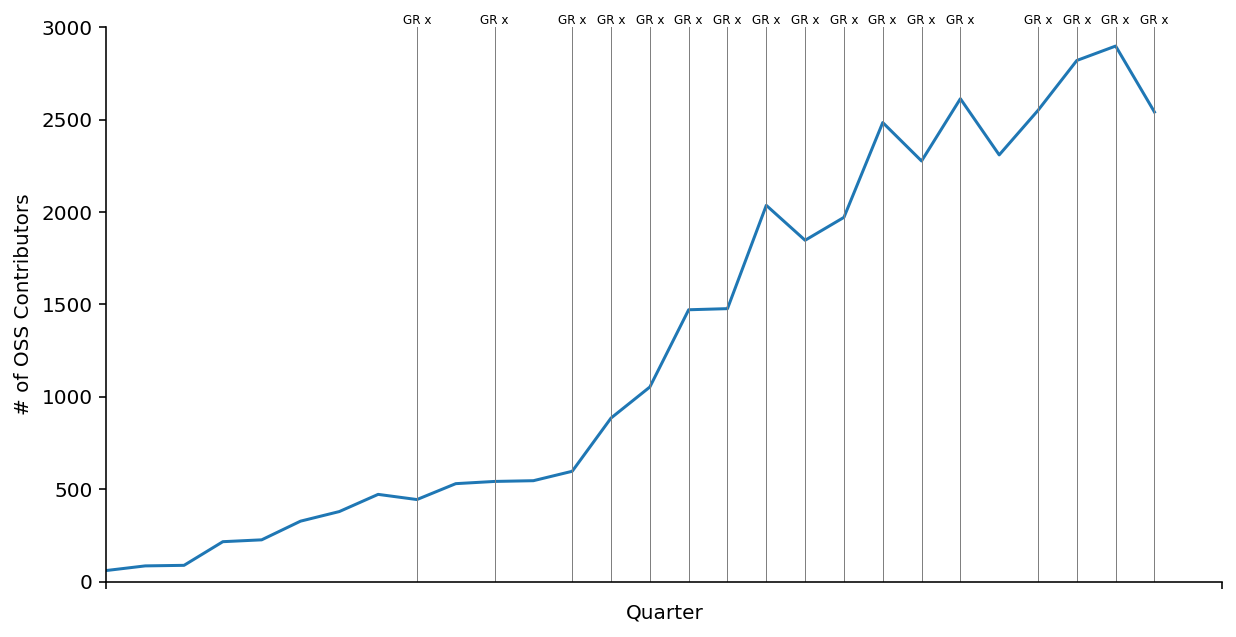

In [126]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10,5), dpi=144, facecolor='white')

grant_streams = grants.groupby('quarter')['total_usd'].sum()
grant_streams = grant_streams[grant_streams>0]

impact.groupby('quarter')['from_name'].nunique().apply(int).plot(kind='line', ax=ax)
for quarter, amount in grant_streams.items():
    q = quarter_mapping.get(quarter)
    #lbl = f"GR{q-15}" if i < 17 else f"GG{q-15}"
    lbl = "GR x"
    ax.text(s=lbl, x=q, y=3000, ha='center', va='bottom', fontsize=6)
    ax.axvline(x=q, color='grey', lw=.5)
    
start_q, end_q = quarter_mapping.get("2017Q1"), quarter_mapping.get("2023Q4")
ax.set_xlim(start_q, )    
ax.set_ylim(0,3000)
sns.despine()
ax.set_xlabel("Quarter")
ax.set_ylabel("# of OSS Contributors")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))

In [130]:
impact.groupby('quarter')['from_name'].nunique().apply(int).index

Index(['2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2', '2016Q3',
       '2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2',
       '2018Q3', '2018Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1',
       '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3', '2021Q4',
       '2022Q1', '2022Q2', '2022Q3', '2022Q4', '2023Q1', '2023Q2', '2023Q3',
       '2023Q4'],
      dtype='object', name='quarter')